In [164]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from patsy import dmatrices
pd.options.mode.chained_assignment = None

from sklearn import preprocessing

from sklearn.metrics import accuracy_score, roc_curve, auc
roc_auc_score, classification_report, confusion_matrix

from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.learning_curve import learning_curve
from sklearn.grid_search import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


%matplotlib inline

In [2]:
df = pd.read_csv("3355.csv")

//anaconda/lib/python2.7/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (11,14,35,36,37) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


###Condensing dataframe down to features to explore

In [235]:
df2 = df[[
'CASENUM','YEAROB1','SEX','RACE','ETHNIC', 
'ADTYP','RELTYP','NFRCTNS',
'DRUGTRT','ALCTRT','SEXTRT','EDUCAT','VOCAT',
'SMPOFF5','RELAGE','SNTLN','TMSRV','PCTSRV',
'A001CNT', 'A001YR','A001MO','A001ST','A001FM1', 'A001OFF1',
'J001MO', 'J001YR', 'J001CNT', 'J001OFF1', 'J001FM1', 'J001CNV1', 'J001CNF1', 'J001PJP1', 'J001PMX1', 'J001PRB1',
'REARR','ROTST','PRIR','POTST']]
df2

,CASENUM,YEAROB1,SEX,RACE,ETHNIC,ADTYP,RELTYP,NFRCTNS,DRUGTRT,ALCTRT,...,J001FM1,J001CNV1,J001CNF1,J001PJP1,J001PMX1,J001PRB1,REARR,ROTST,PRIR,POTST
0,1,1932,MALE,WHITE,HISPANIC,"MANDATORY PAROLE RELEASE REVOCATION, NO NEW SE...",OTHER UNCONDITIONAL RELEASE,INMATE HAS RECORD,UNKNOWN,UNKNOWN,...,MISDEMEANOR,CONVICTED,CONFINED,JAIL,0.66,99899899.9,4,0,93,0
1,2,1929,MALE,WHITE,HISPANIC,COURT COMMITMENT,OTHER CONDITIONAL RELEASE,NO RECORD,UNKNOWN,UNKNOWN,...,NOT APPLICABLE,NOT APPLICABLE,NOT APPLICABLE,NOT APPLICABLE,99899899.90,99899899.9,1,0,30,0
2,3,1934,MALE,WHITE,HISPANIC,COURT COMMITMENT,PAROLE BOARD DECISION-SERVED NO MINIMUM,INMATE HAS RECORD,UNKNOWN,UNKNOWN,...,FELONY,CONVICTED,CONFINED,PRISON,60.00,1000000.0,1,0,9,6
3,4,1931,MALE,BLACK,NON-HISPANIC,"MANDATORY PAROLE RELEASE REVOCATION, NO NEW SE...",OTHER UNCONDITIONAL RELEASE,NO RECORD,UNKNOWN,UNKNOWN,...,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,1000000.00,1000000.0,888,888,888,888
4,5,1942,MALE,WHITE,NON-HISPANIC,"MANDATORY PAROLE RELEASE REVOCATION, NO NEW SE...",EXPIRATION OF SENTENCE,NO RECORD,UNKNOWN,UNKNOWN,...,NOT APPLICABLE,NOT APPLICABLE,NOT APPLICABLE,NOT APPLICABLE,99899899.90,99899899.9,1,0,3,0
5,6,1936,MALE,WHITE,NON-HISPANIC,"ESCAPEE-AWOL RETURNED, NO NEW SENTENCE","RELEASE TO CUSTODY, DETAINER, OR WARRANT",NO RECORD,UNKNOWN,UNKNOWN,...,FELONY,CONVICTED,CONFINED,PRISON,18.00,1000000.0,1,888,888,888
6,7,1947,FEMALE,WHITE,HISPANIC,COURT COMMITMENT,"RELEASE TO CUSTODY, DETAINER, OR WARRANT",NO RECORD,UNKNOWN,UNKNOWN,...,UNKNOWN,NOT CONVICTED,NOT APPLICABLE,NOT CONVICTED,1000000.00,1000000.0,3,888,888,888
7,8,1944,MALE,WHITE,NON-HISPANIC,"MANDATORY PAROLE RELEASE REVOCATION, NO NEW SE...",MANDATORY PAROLE RELEASE,INMATE HAS RECORD,UNKNOWN,UNKNOWN,...,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,1000000.00,1000000.0,888,888,888,888
8,9,1942,MALE,AMERICAN INDIAN/ALEUTIAN,NON-HISPANIC,COURT COMMITMENT,EXPIRATION OF SENTENCE,INMATE HAS RECORD,UNKNOWN,UNKNOWN,...,NOT APPLICABLE,NOT APPLICABLE,NOT APPLICABLE,NOT APPLICABLE,99899899.90,99899899.9,3,0,7,0
9,10,1939,MALE,WHITE,HISPANIC,"PROBATION REVOCATION, NEW SENTENCE",OTHER CONDITIONAL RELEASE,INMATE HAS RECORD,UNKNOWN,UNKNOWN,...,NOT APPLICABLE,NOT APPLICABLE,NOT APPLICABLE,NOT APPLICABLE,99899899.90,99899899.9,3,0,16,0


###Replacing unknown numeric values with nan (for now)

In [236]:
df2['YEAROB1'] = df2['YEAROB1'].replace(9999,np.nan)
df2['A001YR'] = df2['A001YR'].replace(9999,np.nan)
df2['A001YR'] = df2['A001YR'].replace(9998,np.nan)
df2['REARR'] = df2['REARR'].replace(888,np.nan)
df2['ROTST'] = df2['ROTST'].replace(888,np.nan)
df2['PRIR'] = df2['PRIR'].replace(888,np.nan)
df2['POTST'] = df2['POTST'].replace(888,np.nan)
df2['RELAGE'] = df2['RELAGE'].replace(99999999.99,np.nan)
df2['RELAGE'] = df2['RELAGE'].replace(100000000.00,np.nan)
df2['TMSRV'] = df2['TMSRV'].replace(99899899.88,np.nan)
df2['TMSRV'] = df2['TMSRV'].replace(998999.00,np.nan)
df2['SNTLN'] = df2['SNTLN'].replace(99899899.88,np.nan)
df2['SNTLN'] = df2['SNTLN'].replace(998999.00,np.nan)
df2['PCTSRV'] = df2['PCTSRV'].replace(99899899.88,np.nan)
df2['PCTSRV'] = df2['PCTSRV'].replace(998999.00,np.nan)
df2['A001CNT'] = df2['A001CNT'].replace(99,np.nan)
df2['A001CNT'] = df2['A001CNT'].replace(98,np.nan)
df2['J001YR'] = df2['J001YR'].replace(9999,np.nan)

###Adding calculated features

In [237]:
df2['AGE_FIRST_OFF'] = df2.A001YR - df2.YEAROB1
df2['AGE_FIRST_OFF'][df2['AGE_FIRST_OFF'] < 16] = np.nan
#df2['AVG_YRLY_ARR'] = 0
df2['TOT_PRARR'] = (df2['PRIR'] + df2['POTST'])
df2['CAREER_LEN'] = (1994-df2['A001YR'])
df2['SNTLN_YRS'] = df2.SNTLN/12
df2['TOTREARR'] = df2.REARR + df2.ROTST
df2['RESP'] = 0
df2['RESP'][df2['TOTREARR'] > 0] = 1

In [238]:
treatments = ['DRUGTRT', 'ALCTRT', 'SEXTRT', 'EDUCAT', 'VOCAT']

for x in treatments:
    df2[x] = df2[x].replace('UNKNOWN',0)
    df2[x] = df2[x].replace('INMATE DID NOT PARTICIPATE',0)
    df2[x] = df2[x].replace('INMATE PARTICIPATED BUT UNKNOWN IF COMPLETED',1)
    df2[x] = df2[x].replace('INMATE PARTICIPATED IN PROGRAM & COMPLETED IT',1)
    df2[x] = df2[x].replace('INMATE PARTICIPATED BUT DID NOT COMPLETE',1)

df2['TREATMENT'] = df2.DRUGTRT + df2.ALCTRT + df2.SEXTRT + df2.EDUCAT + df2.VOCAT
for x in treatments:
    df2.drop(x, axis=1, inplace=True)
df2['TREATMENT'][df2['TREATMENT'] > 0] = 1

###Counting nan percentage

In [239]:
features = df2.columns.values.tolist()

In [240]:
for feature in features:
    per = float(float(len(df2[feature]) - df2[feature].count())/len(df2[feature]))
    if per > 0.0:
        print feature, "has %0.2f percent missing values" % (per*100)

YEAROB1 has 0.03 percent missing values
RELAGE has 0.13 percent missing values
TMSRV has 12.50 percent missing values
PCTSRV has 18.14 percent missing values
A001CNT has 3.18 percent missing values
A001YR has 2.55 percent missing values
J001YR has 15.24 percent missing values
REARR has 2.53 percent missing values
ROTST has 18.88 percent missing values
PRIR has 12.50 percent missing values
POTST has 12.50 percent missing values
AGE_FIRST_OFF has 5.48 percent missing values
TOT_PRARR has 12.50 percent missing values
CAREER_LEN has 2.55 percent missing values
TOTREARR has 18.88 percent missing values


###Cleaning up missing data

In [241]:
#Hard coded the mode of the ROTST & POTST column
df2['ROTST']= df2.ROTST.replace(np.nan,0)
df2['POTST']= df2.POTST.replace(np.nan,0)

In [245]:
df2['PRIR'] = df2.PRIR.replace(np.nan,df2.PRIR.mean())
df2['REARR'] = df2.REARR.replace(np.nan,df2.REARR.mean())
df2['PCTSRV'] = df2.PCTSRV.replace(np.nan,df2.PCTSRV.mean())
df2['TMSRV'] = df2.TMSRV.replace(np.nan,df2.TMSRV.mean())

###Recalculate features with cleaned data

In [246]:
df2['AGE_FIRST_OFF'] = df2.A001YR - df2.YEAROB1
df2['AGE_FIRST_OFF'][df2['AGE_FIRST_OFF'] < 16] = np.nan
#df2['AVG_YRLY_ARR'] = 0
df2['TOT_PRARR'] = (df2['PRIR'] + df2['POTST'])
df2['CAREER_LEN'] = (1994-df2['A001YR'])
df2['SNTLN_YRS'] = df2.SNTLN/12
df2['TOTREARR'] = df2.REARR + df2.ROTST
df2['RESP'] = 0
df2['RESP'][df2['TOTREARR'] > 0] = 1

###Recheck for missing values

In [247]:
for feature in features:
    per = float(float(len(df2[feature]) - df2[feature].count())/len(df2[feature]))
    if per > 0.0:
        print feature, "has %0.2f percent missing values" % (per*100)

YEAROB1 has 0.03 percent missing values
RELAGE has 0.13 percent missing values
A001CNT has 3.18 percent missing values
A001YR has 2.55 percent missing values
J001YR has 15.24 percent missing values
AGE_FIRST_OFF has 5.48 percent missing values
CAREER_LEN has 2.55 percent missing values


###Look at means for each group to be classified

In [248]:
df2.groupby('RESP').mean()

,CASENUM,YEAROB1,RELAGE,SNTLN,TMSRV,PCTSRV,A001CNT,A001YR,J001YR,J001CNT,...,REARR,ROTST,PRIR,POTST,AGE_FIRST_OFF,TOT_PRARR,CAREER_LEN,SNTLN_YRS,TOTREARR,TREATMENT
RESP,,,,,,,,,,,,,,,,,,,,,
0,1646.699693,1958.202407,35.834532,71.708477,30.69262,7.189998e+07,1.512116,1983.049657,4991.074572,33.182199,...,0.000000,0.000000,4.886224,0.792492,25.061670,5.678716,10.950343,5.975706,0.00000,0.208358
1,1615.692796,1962.324688,31.672924,59.240011,24.63484,1.175770e+08,1.494569,1983.205909,5278.597988,38.035143,...,2.649104,0.231646,8.537807,1.027215,21.094002,9.565022,10.794091,4.936668,2.88075,0.226375


###Visualize distribution of features

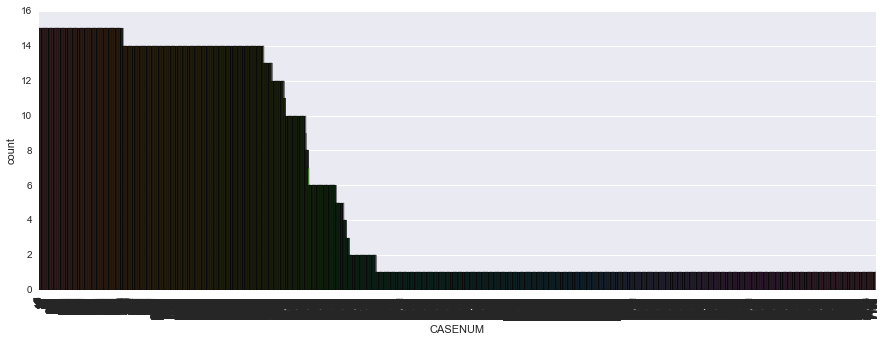

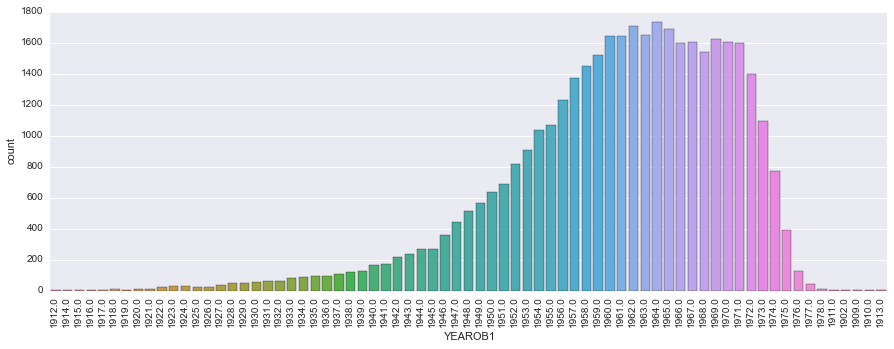

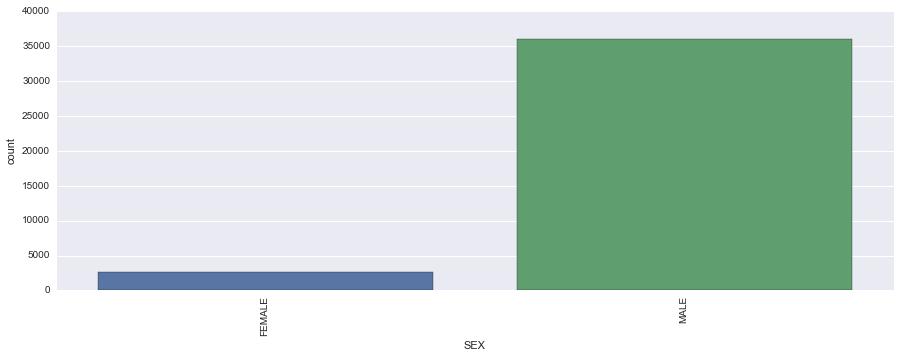

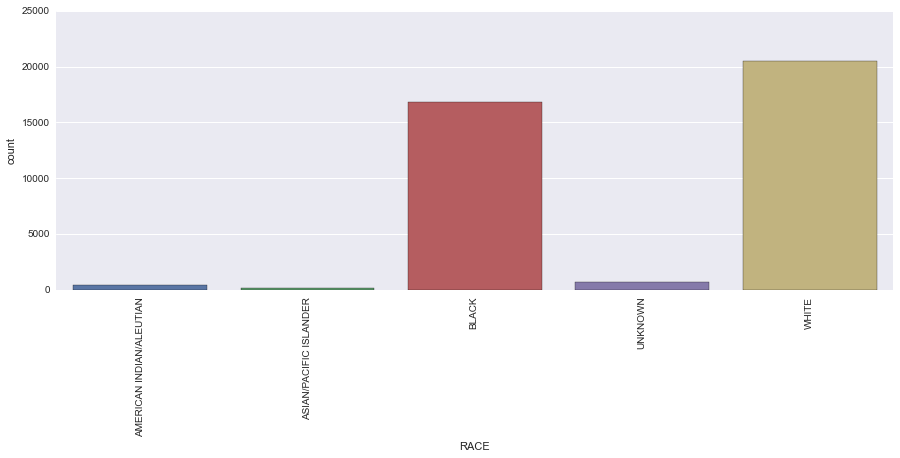

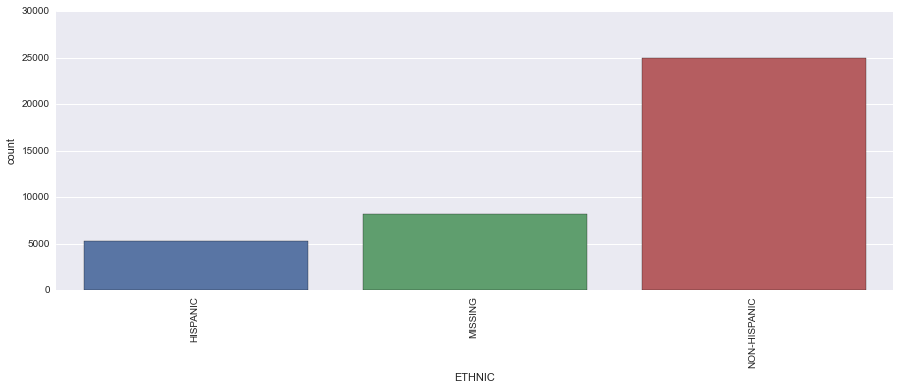

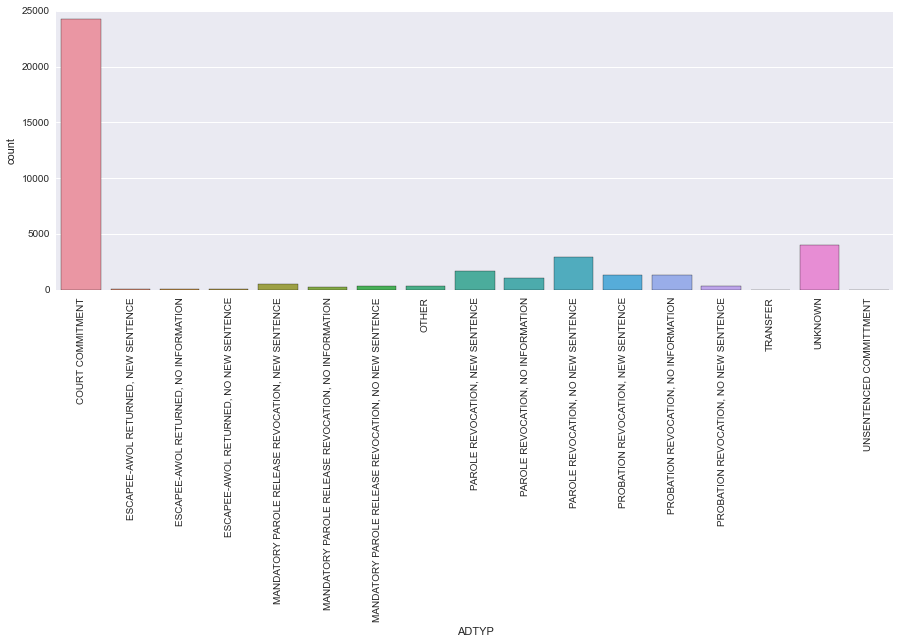

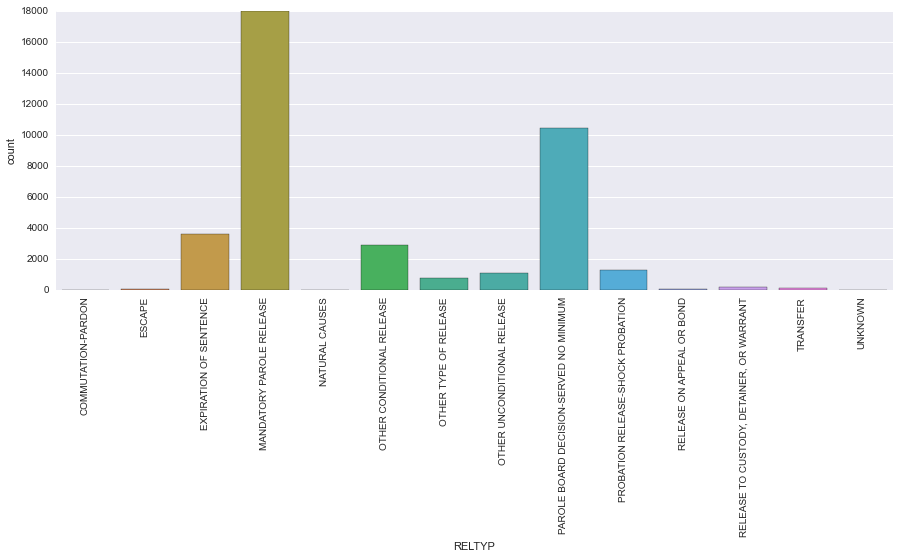

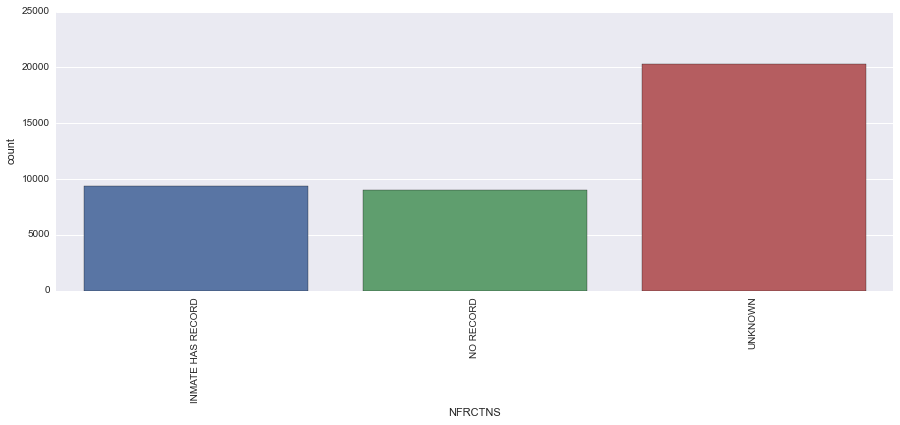

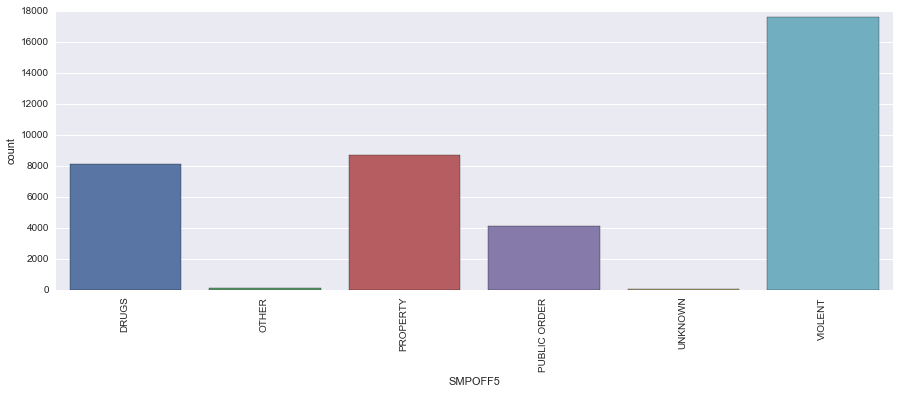

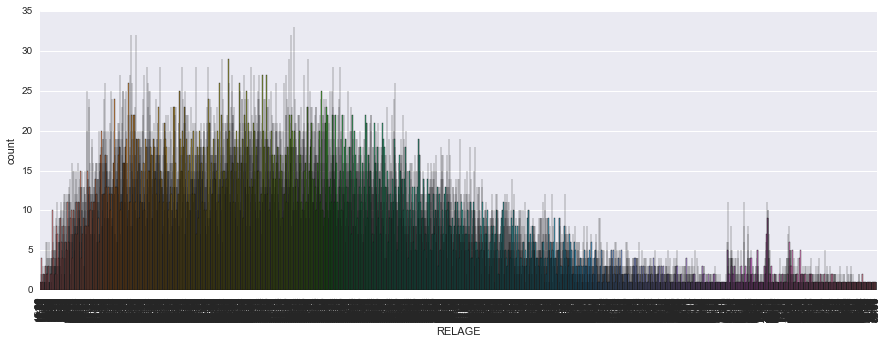

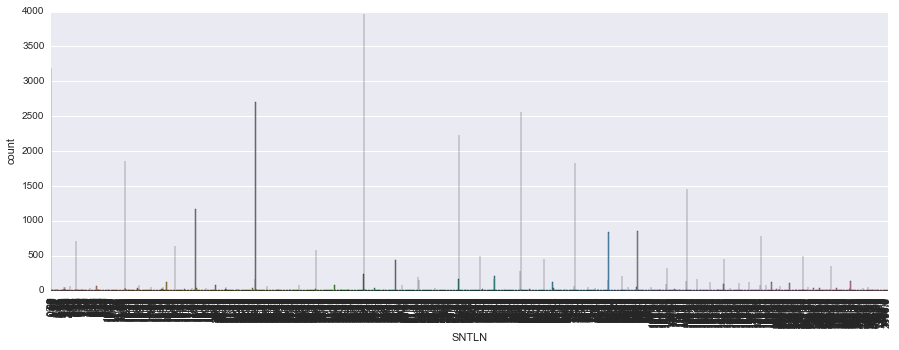

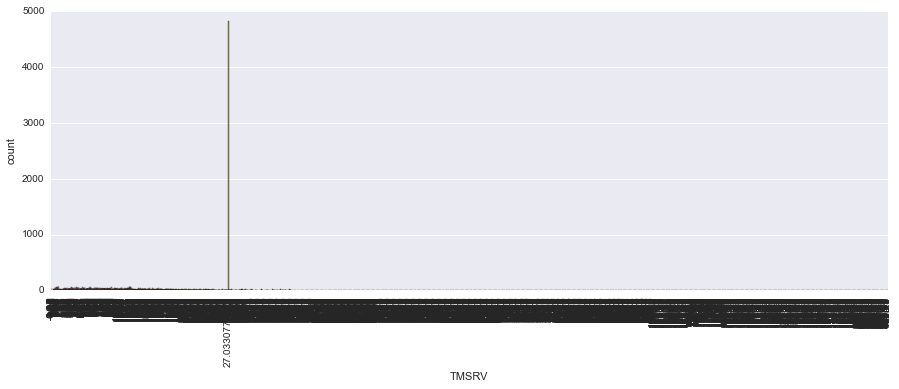

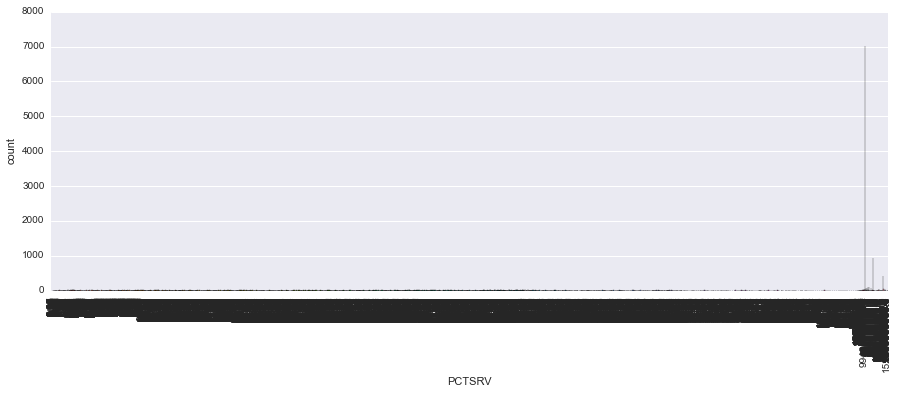

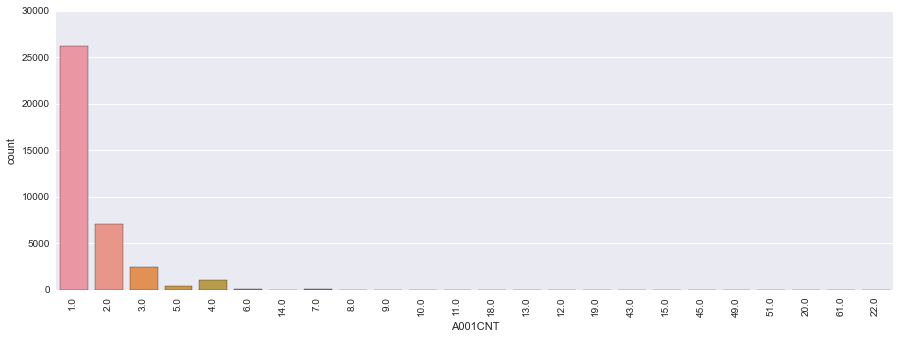

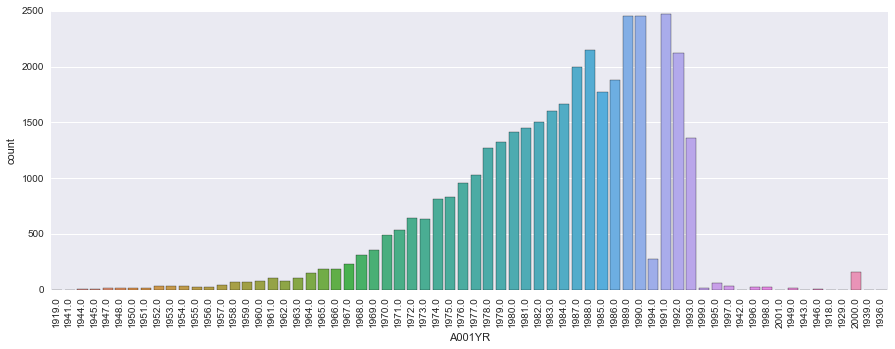

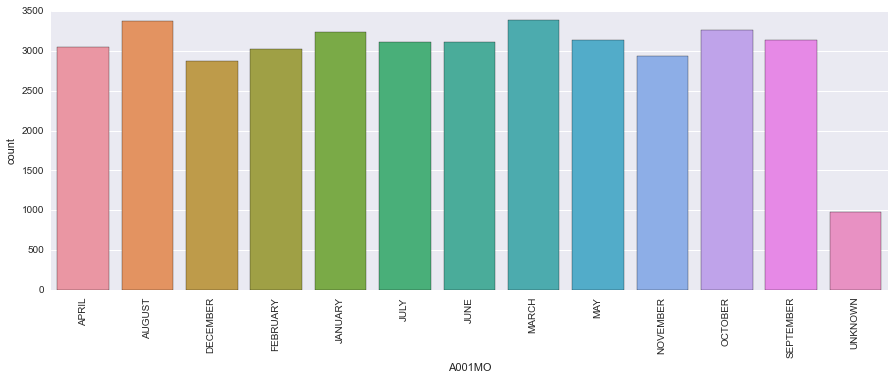

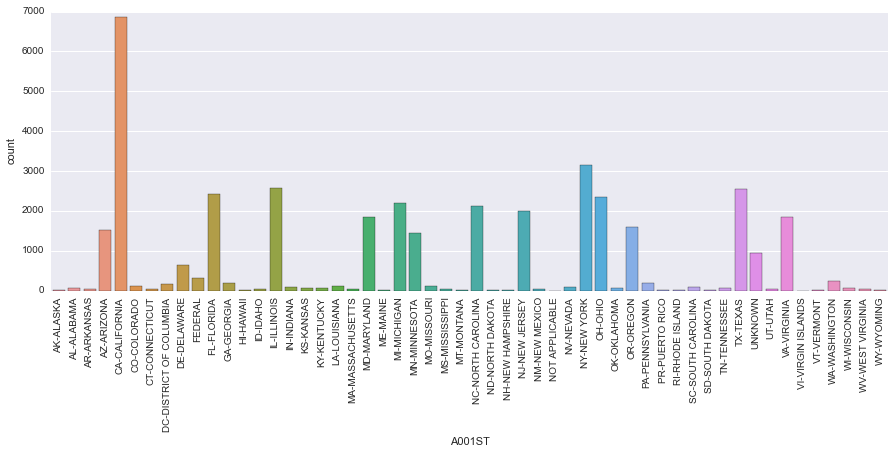

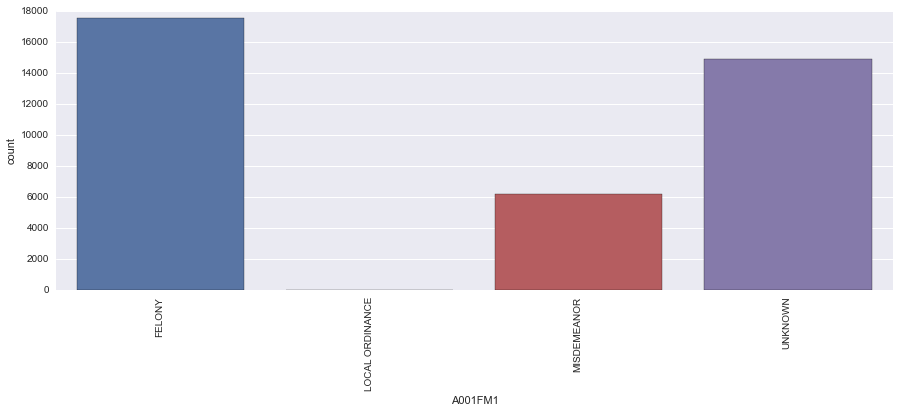

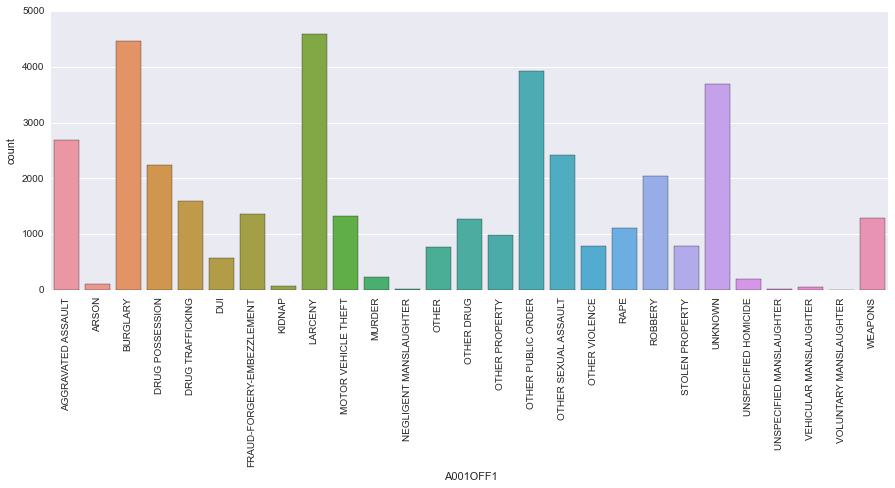

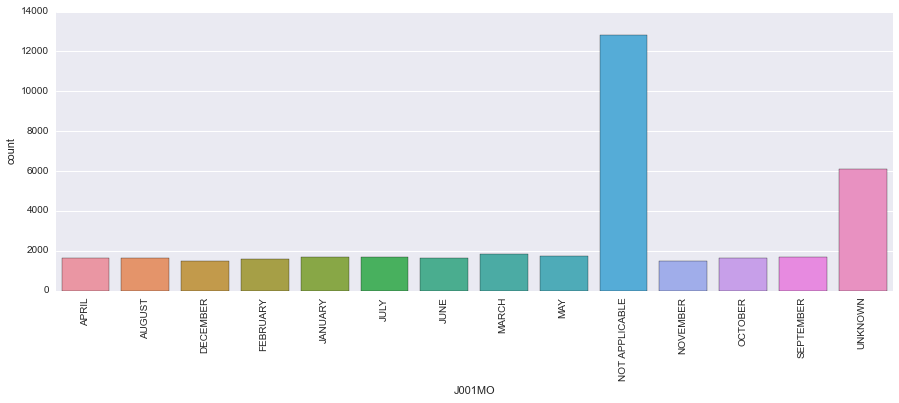

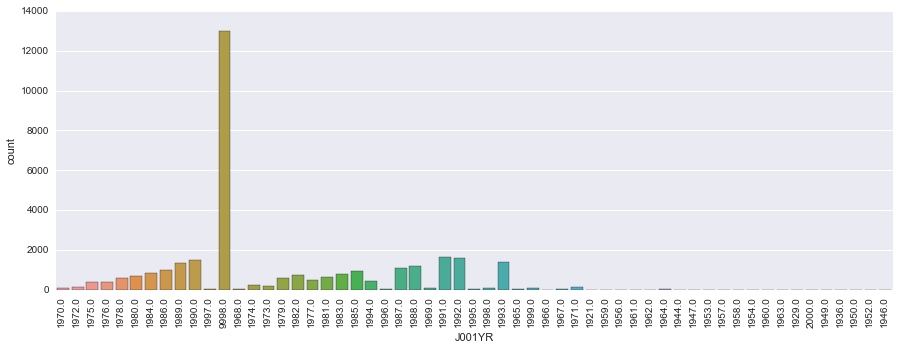

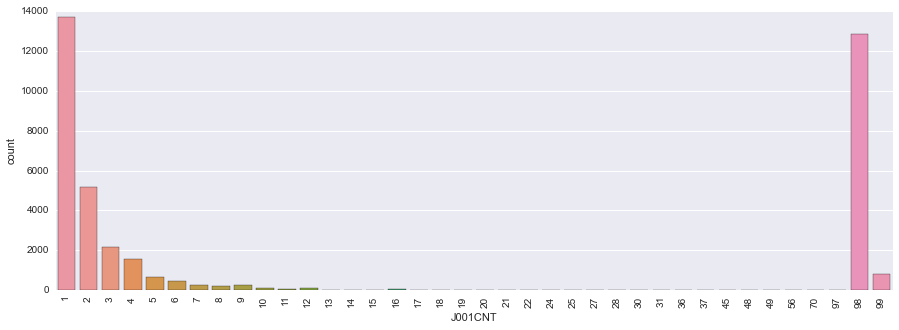

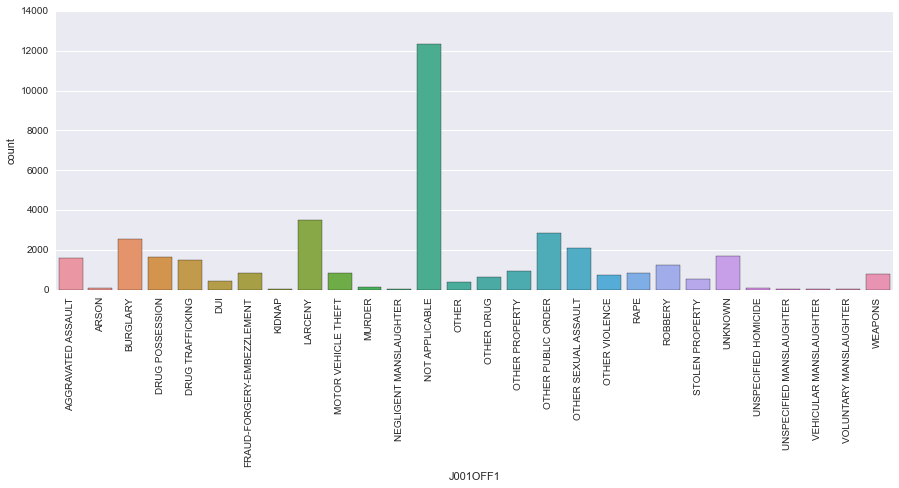

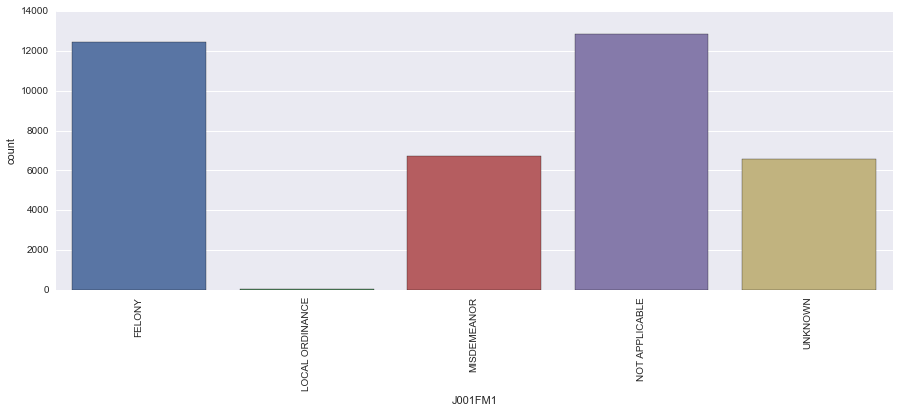

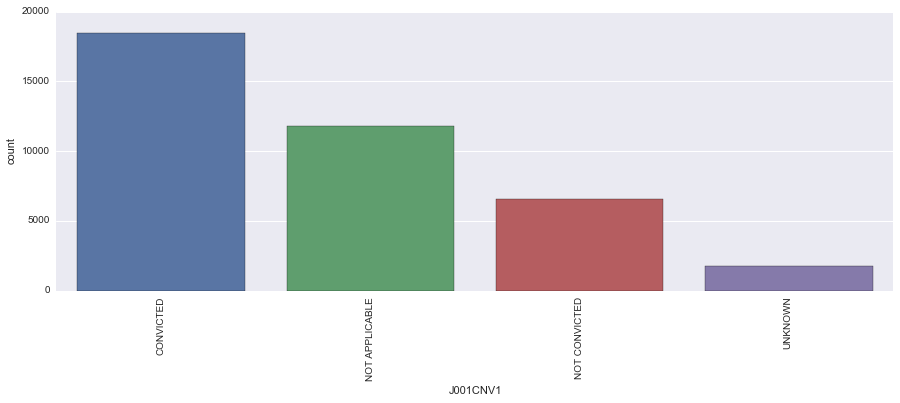

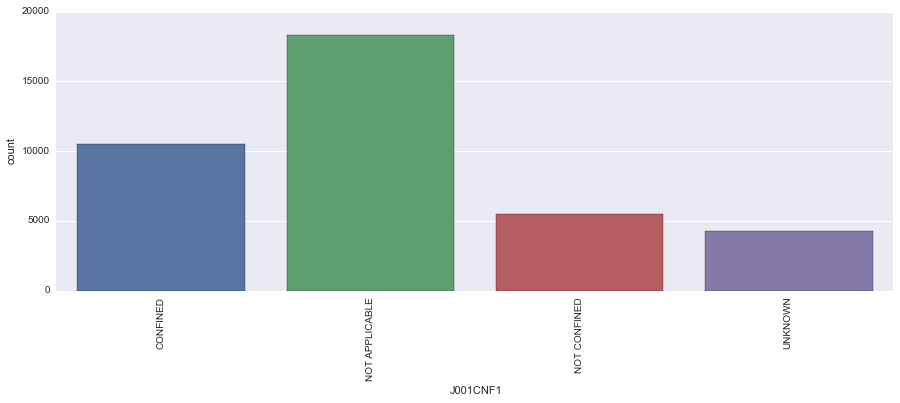

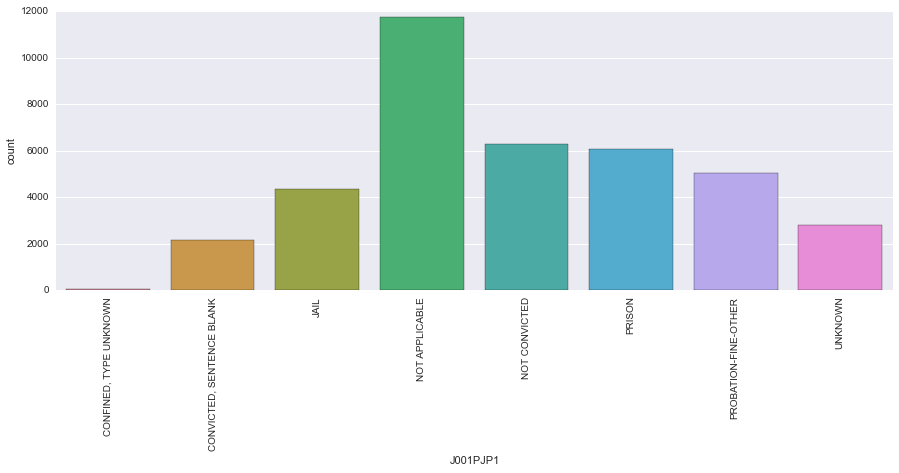

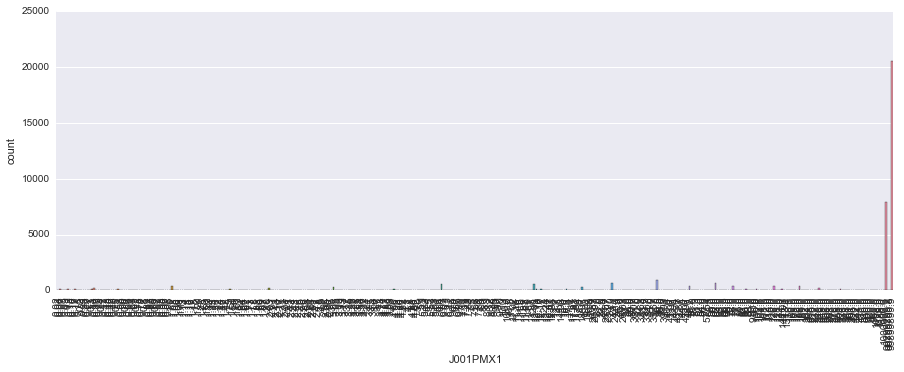

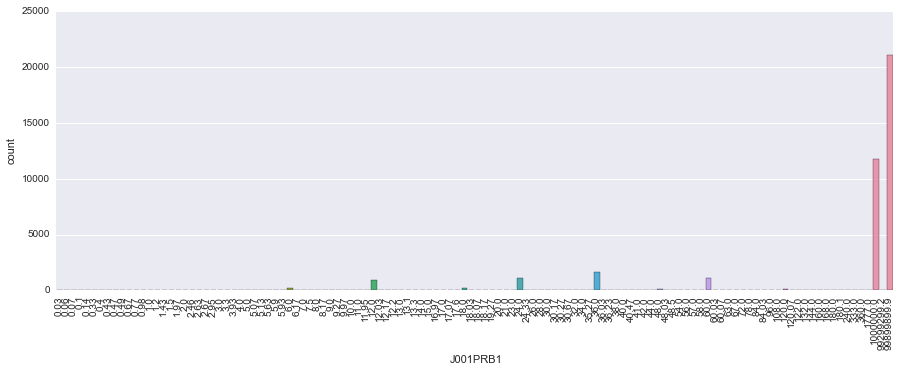

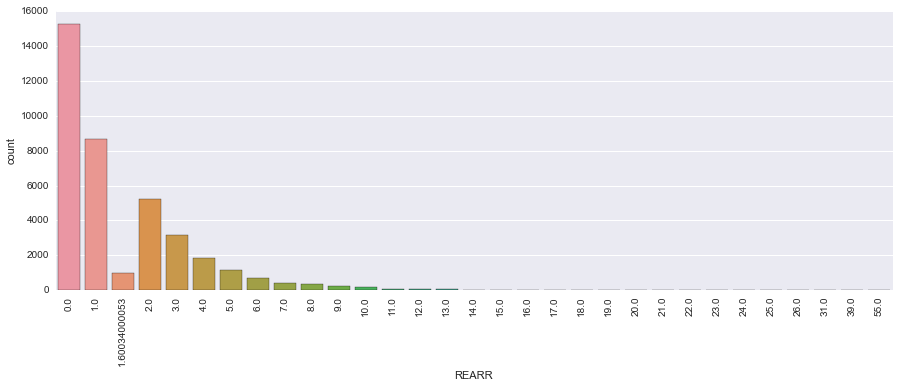

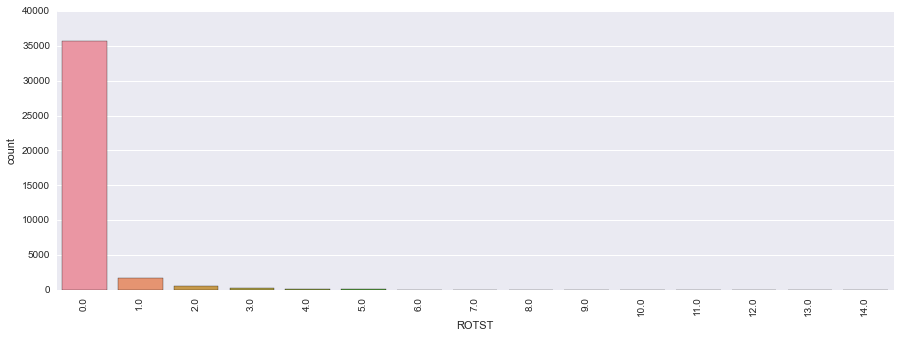

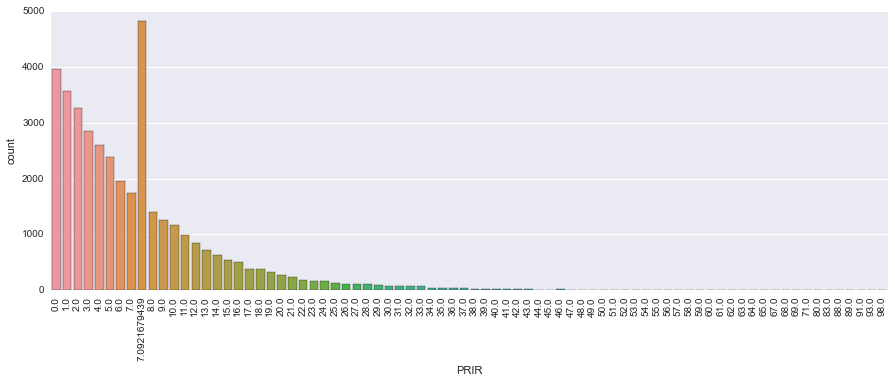

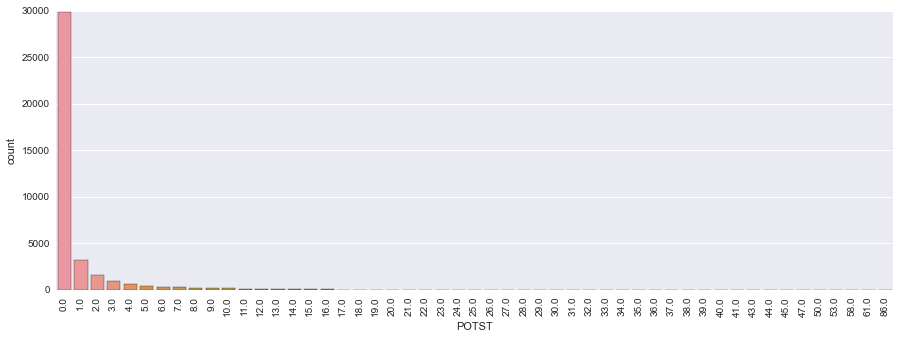

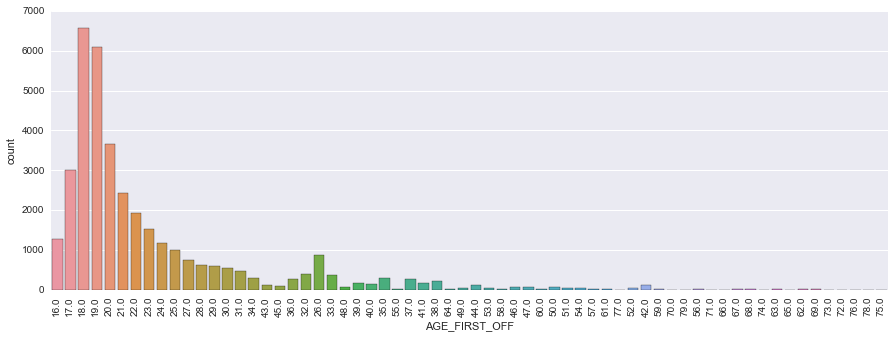

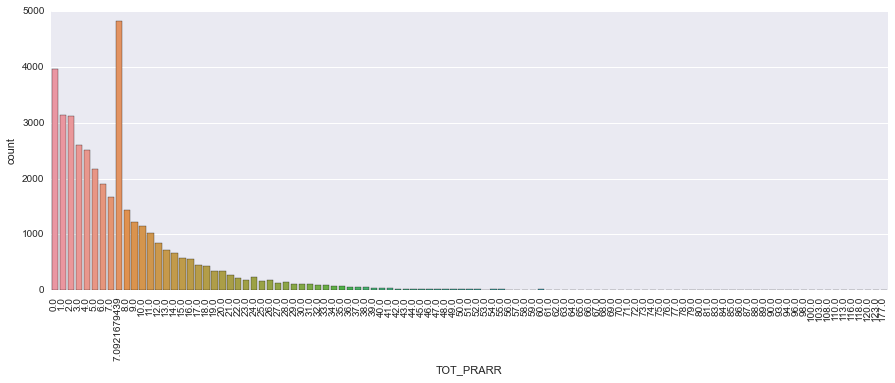

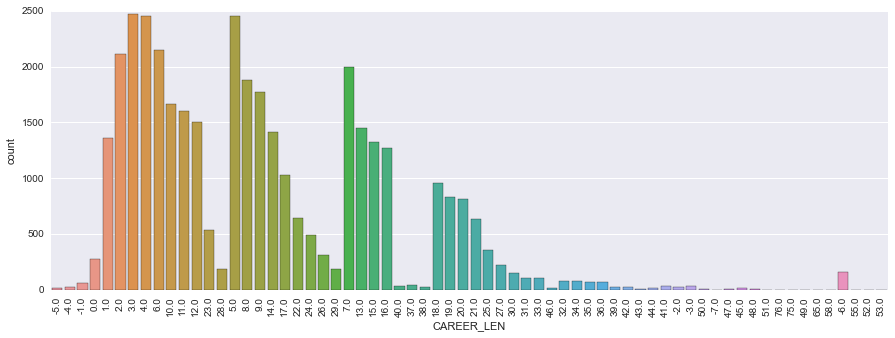

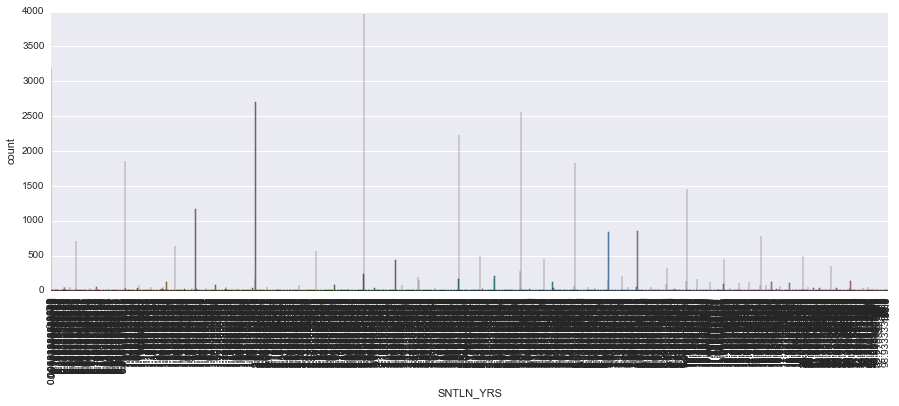

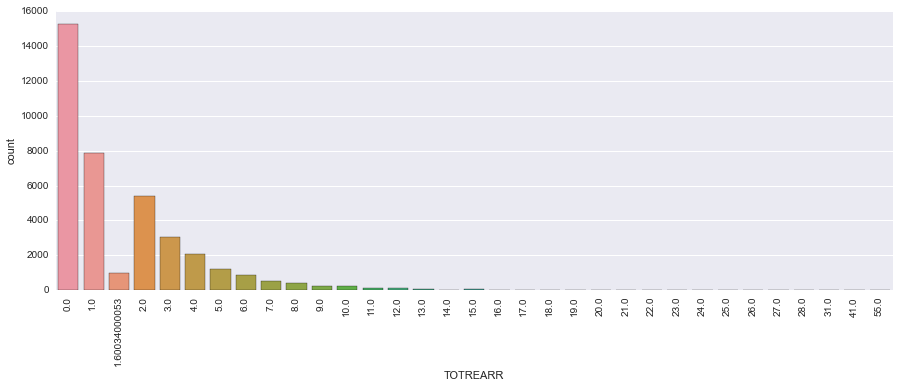

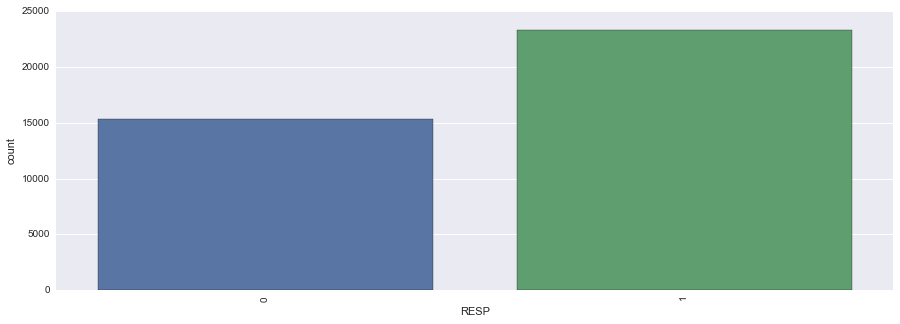

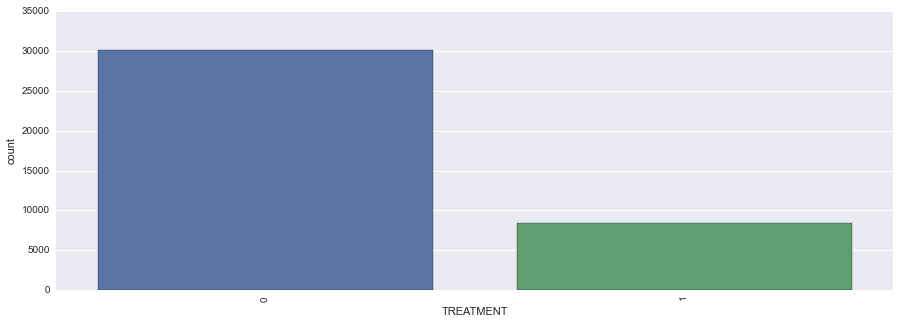

In [249]:
def make_plot(x):
    plt.figure(figsize = (15,5))
    sns.countplot(sorted(df2[x]))
    plt.xticks(rotation = 90)
    plt.xlabel(x)
    plt.show()

for feature in features:
    make_plot(feature)

###Set up selected features, train/test split and scale

In [269]:
#y, X = dmatrices('RESP ~ SEX1 + RACE1+ETHNIC1+RELTYP+NFRCTNS+C(TREATMENT)+ADTYP+SMPOFF5+np.log(RELAGE)+np.log(TMSRV+1)+np.log(TOT_PRARR+1)+A001FM1+np.log(AGE_FIRST_OFF)+PCTSRV', data=df2, return_type='dataframe')
#y, X = dmatrices('RESP ~ np.log(RELAGE) + TMSRV + np.log(TOT_PRARR+1) + np.log(PCTSRV) + np.log(AGE_FIRST_OFF) + SMPOFF5+ A001FM1 + C(TREATMENT)', data=df2, return_type='dataframe')
#y, X = dmatrices('RESP ~ TOT_PRARR', data=df2, return_type='dataframe')
y, X = dmatrices('RESP ~ ADTYP + np.log(A001CNT+1) + SEX +RELTYP + J001PJP1+ np.log(RELAGE+1) + np.log(TMSRV+1) + np.log(TOT_PRARR+1) + PCTSRV + np.log(AGE_FIRST_OFF) + SMPOFF5+ A001FM1 + C(TREATMENT) + SNTLN_YRS', data=df2, return_type='dataframe')


y = np.ravel(y)

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=7)

std_scale = preprocessing.StandardScaler().fit(x_train)
x_train = std_scale.transform(x_train)
x_test = std_scale.transform(x_test)

###Baseline predictor


In [251]:
def always_reoffend(x):
    return [1] * len(x)
y_pred = always_reoffend(x_test)

print "Baseline = %0.2f" % accuracy_score(y_test, y_pred) 

Baseline = 0.59


###Train model and evaluate test accuracy

In [270]:
def test_model(name, main_model):
    model = main_model
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    print name, "test accuracy score:", accuracy_score(y_test, model.predict(x_test))
    
#test_model("KNN", KNeighborsClassifier())
#test_model("Logistic Regression", LogisticRegression())
#test_model("Gaussian Naive Bayes", GaussianNB())
test_model("SVM Classifier", SVC())
#test_model("Decision Tree", DecisionTreeClassifier())
#test_model("Random Forest", RandomForestClassifier())

SVM Classifier test accuracy score: 0.686555641337


###Look at feature importance

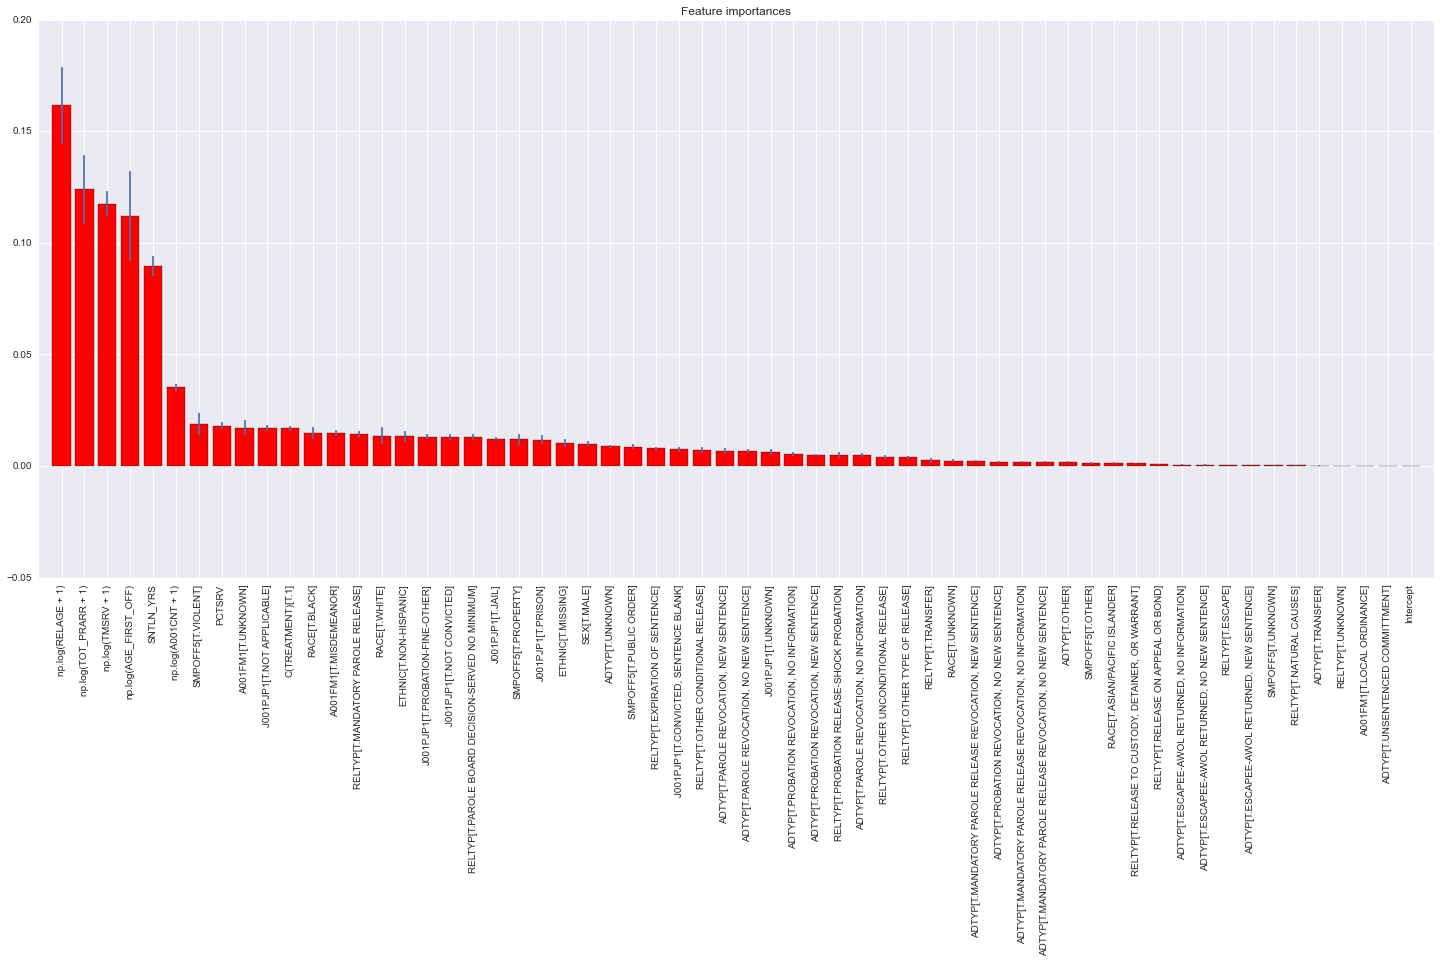

In [253]:
model = RandomForestClassifier()
model.fit(x_train, y_train)
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

plt.figure(figsize = (25,10))
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(len(indices)), X.columns[indices], rotation = 90)
plt.xlim([-1, len(indices)])
plt.show()

###Create dataframe with confusion matrix metrics for each feature in model

In [256]:
cm_features = ['RELAGE', 'TMSRV', 'TOT_PRARR', 'PCTSRV', 'AGE_FIRST_OFF']

In [258]:
model = SVC(probability= True)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

In [259]:
cm = confusion_matrix(y_test, model.predict(x_test))

In [260]:
cm_df = pd.DataFrame(np.hstack((cm[0],cm[1])))
cm_df

,0
0,1729
1,1996
2,782
3,4560


In [261]:
y, X = dmatrices('RESP ~ RELAGE', data=df2, return_type='dataframe')

y = np.ravel(y)

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=7)

std_scale = preprocessing.StandardScaler().fit(x_train)
x_train = std_scale.transform(x_train)
x_test = std_scale.transform(x_test)

model = SVC()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
cm = confusion_matrix(y_test, model.predict(x_test))
cm_df['RELAGE'] = np.hstack((cm[0],cm[1]))

In [262]:
y, X = dmatrices('RESP ~ TMSRV', data=df2, return_type='dataframe')

y = np.ravel(y)

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=7)

std_scale = preprocessing.StandardScaler().fit(x_train)
x_train = std_scale.transform(x_train)
x_test = std_scale.transform(x_test)

model = SVC()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
cm = confusion_matrix(y_test, model.predict(x_test))
cm_df['TMSRV'] = np.hstack((cm[0],cm[1]))

In [263]:
y, X = dmatrices('RESP ~ TOT_PRARR', data=df2, return_type='dataframe')

y = np.ravel(y)

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=7)

std_scale = preprocessing.StandardScaler().fit(x_train)
x_train = std_scale.transform(x_train)
x_test = std_scale.transform(x_test)

model = SVC()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
cm = confusion_matrix(y_test, model.predict(x_test))
cm_df['TOT_PRARR'] = np.hstack((cm[0],cm[1]))

In [264]:
y, X = dmatrices('RESP ~ PCTSRV', data=df2, return_type='dataframe')

y = np.ravel(y)

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=7)

std_scale = preprocessing.StandardScaler().fit(x_train)
x_train = std_scale.transform(x_train)
x_test = std_scale.transform(x_test)

model = SVC()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
cm = confusion_matrix(y_test, model.predict(x_test))
cm_df['PCTSRV'] = np.hstack((cm[0],cm[1]))

In [265]:
y, X = dmatrices('RESP ~ AGE_FIRST_OFF', data=df2, return_type='dataframe')

y = np.ravel(y)

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=7)

std_scale = preprocessing.StandardScaler().fit(x_train)
x_train = std_scale.transform(x_train)
x_test = std_scale.transform(x_test)

model = SVC()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
cm = confusion_matrix(y_test, model.predict(x_test))
cm_df['AGE_FIRST_OFF'] = np.hstack((cm[0],cm[1]))

In [266]:
cm_df.columns.values[0] ='TOTAL' 
cm_df

,TOTAL,RELAGE,TMSRV,TOT_PRARR,PCTSRV,AGE_FIRST_OFF
0,1729,786,461,1135,0,1140
1,1996,2991,3327,2653,3788,2671
2,782,467,383,610,0,614
3,4560,5400,5485,5258,5868,4702


In [267]:
cm_plot_df = cm_df.T
cm_plot_df['Correct']= cm_plot_df[0] + cm_plot_df[3]
cm_plot_df['Incorrect']= cm_plot_df[1] + cm_plot_df[2]
cm_plot_df = cm_plot_df[['Correct', 'Incorrect']]
cm_plot_df

,Correct,Incorrect
TOTAL,6289,2778
RELAGE,6186,3458
TMSRV,5946,3710
TOT_PRARR,6393,3263
PCTSRV,5868,3788
AGE_FIRST_OFF,5842,3285


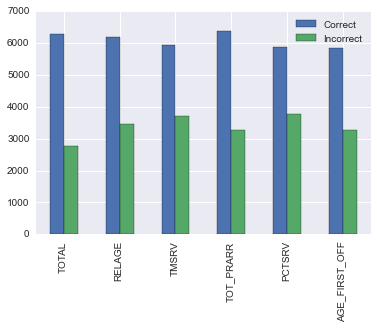

In [268]:
cm_plot_df.plot(kind = "bar")
plt.show()

###Grid search for best parameters for SVC (wait to do this until model is done)

In [255]:
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)

    clf = GridSearchCV(SVC(C=1), tuned_parameters, cv=5,
                       scoring='%s_weighted' % score)
    clf.fit(x_train, y_train)

    print("Best parameters set found on development set:")
    print(clf.best_params_)
    print("Grid scores on development set:")
    for params, mean_score, scores in clf.grid_scores_:
        print("%0.3f (+/-%0.03f) for %r"
              % (mean_score, scores.std() * 2, params))

    print("Detailed classification report:")
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    y_true, y_pred = y_test, clf.predict(x_test)
    print(classification_report(y_true, y_pred))

# Tuning hyper-parameters for precision


KeyboardInterrupt: 